# Telco Customer Churn Prediction

## 1. Introduction

In this notebook, I will build a machine learning model to predict customer churn for a telco company. The dataset contains information about customers, their usage patterns, and whether they churned or not.

* Analyze customer behavior
* Build a machine learning model to predict customer churn
* Evaluate the model with accuracy, precision, recall, and F1 score
* Provide insights on which factors affect customer churn


---

## 2. Import Libraries and Load Data

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [49]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [51]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


---

## 3. Data Cleaning
* Convert TotalCharges to numeric
* Drop missing rows
* Encode categorical variables

In [52]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges'])

# Binary encoding
binary_columns = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_columns:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

# One-hot encoding
categorical_columns = [
    'MultipleLines', 'InternetService', 'OnlineSecurity',
    'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies', 'Contract',
    'PaymentMethod'
]

df = pd.get_dummies(df, columns=categorical_columns)

# Drop customerID column, it is not needed for training
df = df.drop('customerID', axis=1)

---

## 4. Exploratory Data Analysis (EDA)

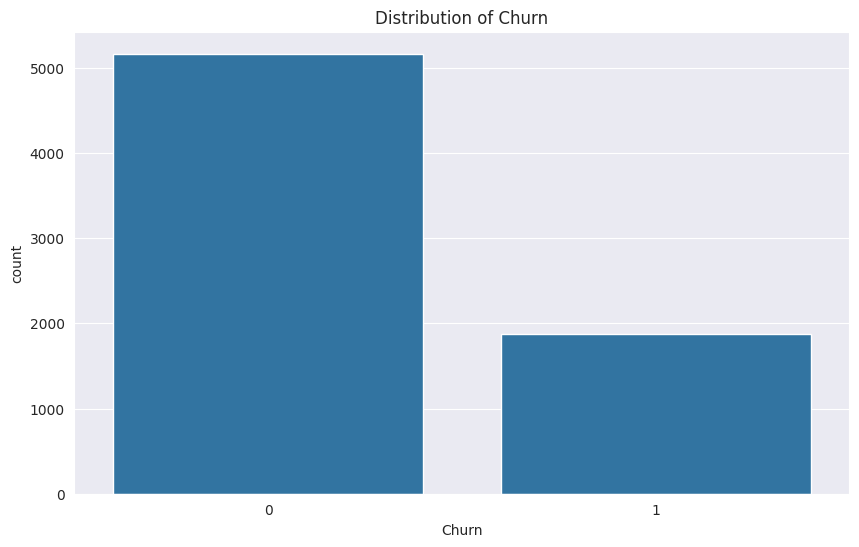

In [53]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Churn', data=df)
plt.title('Distribution of Churn')
plt.show()

In [54]:
df['Churn'].value_counts(normalize=True) * 100

Churn
0    73.421502
1    26.578498
Name: proportion, dtype: float64

*Our dataset is imbalanced, with only 26% of the customers churning.*

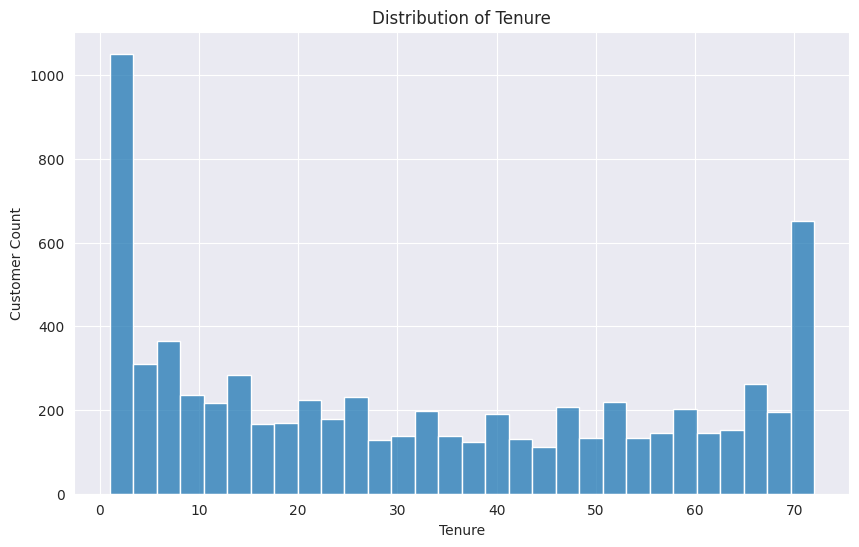

In [55]:
plt.figure(figsize=(10, 6))
sns.histplot(x='tenure', data=df, bins=30)
plt.title('Distribution of Tenure')
plt.xlabel('Tenure')
plt.ylabel('Customer Count')
plt.show()

*Many customers are either very new (low tenure) or have been with the company for a long time (high tenure).*

---

## 5. Train/Test Split

In [56]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

---

## 6. Baseline Models

#### Helper function for model evaluation

In [57]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print('Precision:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    print('F1 Score:', f1_score(y_test, y_pred))

#### LinearSVC

In [58]:
svc = LinearSVC(random_state=42)
svc.fit(X_train, y_train)
evaluate_model(svc, X_test, y_test)

Accuracy: 0.7874911158493249
Precision: 0.6678700361010831
Recall: 0.4719387755102041
F1 Score: 0.5530642750373692


#### RandomForestClassifier

In [59]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
evaluate_model(rf, X_test, y_test)

Accuracy: 0.775408670931059
Precision: 0.6225806451612903
Recall: 0.4923469387755102
F1 Score: 0.5498575498575499


#### XGBoost

In [60]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
evaluate_model(xgb, X_test, y_test)

Accuracy: 0.7725657427149965
Precision: 0.6104294478527608
Recall: 0.5076530612244898
F1 Score: 0.5543175487465181


---

## 7. Addressing Imbalance with SMOTE

In [61]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

xgb_smote = XGBClassifier(random_state=42)
xgb_smote.fit(X_train_res, y_train_res)
evaluate_model(xgb_smote, X_test, y_test)

Accuracy: 0.7661691542288557
Precision: 0.5918367346938775
Recall: 0.5178571428571429
F1 Score: 0.5523809523809524


---

## 8. Hyperparameter Tuning XGBoost with GridSearchCV

In [62]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
}

grid_search = GridSearchCV(XGBClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)
best_model = grid_search.best_estimator_

evaluate_model(best_model, X_test, y_test)

Accuracy: 0.7818052594171997
Precision: 0.6109660574412533
Recall: 0.5969387755102041
F1 Score: 0.6038709677419355


---

## 9. Feature Importance

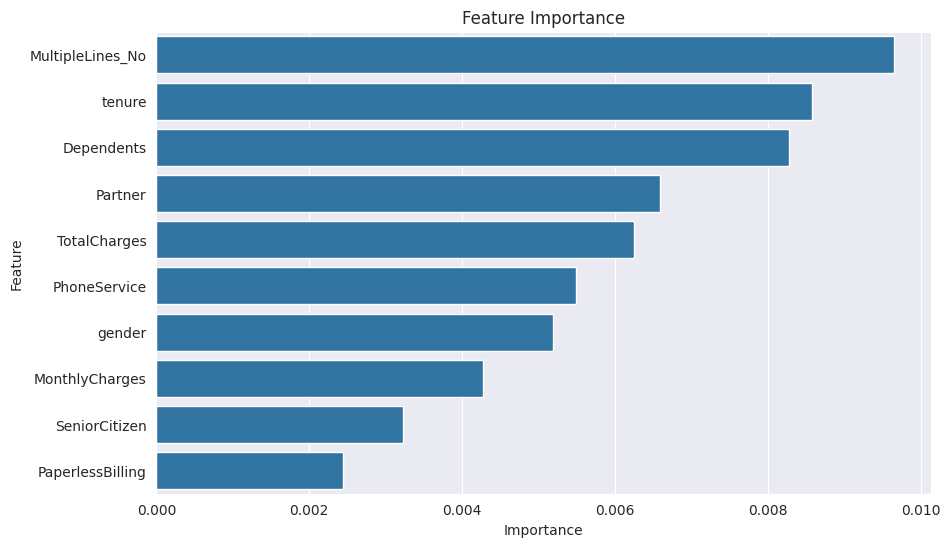

In [64]:
importances = best_model.feature_importances_
features = X.columns
feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp.head(10).sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [66]:
contract_features = [col for col in X.columns if 'Contract' in col]

feat_imp[feat_imp['Feature'].isin(contract_features)] \
    .sort_values(by='Importance', ascending=False)


,Feature,Importance
33,Contract_Month-to-month,0.499106
35,Contract_Two year,0.018152
34,Contract_One year,0.017796


* *Contract Type* is the strongest predictor of churn. Customers with month-to-month contracts are more likely to churn.
* Customers on a 1-year or 2-year contracts are less likely to churn.
* This finding suggests that encouraging customers to sign longer contracts could help reduce churn.
* **MultipleLines_No** and **Dependents** are strong predictors of churn. Customers without multiple lines and without dependents are more likely to churn.
* **Tenure** is also a strong predictor of churn. Customers with low tenure are more likely to churn.
* **MonthlyCharges** and **TotalCharges** indicate that pricing is an important factor in customer retention.